In [1]:
kaggle_env = 0

In [2]:
if not kaggle_env:
    import os
    import sys
    while not os.getcwd().endswith('ml'):
        os.chdir('..')
    sys.path.insert(0, os.getcwd())

In [3]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
from sys import getsizeof
import gc

In [4]:
if kaggle_env:
    COUNT_BATCH_USING = 10
else:
    COUNT_BATCH_USING = 2
TEST_SIZE = 0.1

if kaggle_env:
    input_dir = Path('../input/riiid-test-answer-prediction')
    batched_dir = Path('../input/riiid-split-input-data') / "batched_by_user_train"
    model_dir = Path('../input/lightgb-benchmark')
else:
    input_dir = Path('kaggle_problems/riiid_test_answer_prediction/workspace/data')
    batched_dir = Path('kaggle_problems/riiid_test_answer_prediction/workspace/data') / "batched_by_user_train"
    model_dir = Path('kaggle_problems/riiid_test_answer_prediction/models')

FILE_LIST = [i for i in batched_dir.glob("*.pkl")]


In [5]:
lectures = pd.read_csv("{}/lectures.csv".format(input_dir))
questions = pd.read_csv("{}/questions.csv".format(input_dir))

print("len of lectures={}, len of questions={}".format(len(lectures), len(questions)))

def apply_to_train(files, f):
    for file in files:
        train = pickle.load(open(file, 'rb'))
        yield f(train)

len of lectures=418, len of questions=13523


In [6]:
START_INTERVAL = 4 * 365 * 24 * 60 * 60 * 1000
def enrich_event_time(train, seed):
    np.random.seed(seed)
    
    time_on_server = train.groupby('user_id')['timestamp'].max()
        
    users = train['user_id'].unique()
    start_time = (np.random.rand(len(users)) * (START_INTERVAL - time_on_server)).astype(np.int)
    #np.ones(len(users)) * (START_INTERVAL - time_on_server)
    
    
    user_start_time = pd.DataFrame(data={"user_id": users, "join_time": start_time}).set_index(['user_id'])

    train = pd.concat([train.reset_index(drop=True), 
           user_start_time.reindex(train['user_id'].values).reset_index(drop=True)], axis=1)
    
    #print(train['join_time'].mean())
    #print(train['timestamp'].mean())
    train['event_time'] = train['join_time'] + train['timestamp']
    return train

def train_test_split(data, test_size, seed=42):
    data = enrich_event_time(data, seed)
    data = data.sort_values('event_time')
    
    test_size = int(len(data) * test_size)
    train_size = len(data) - test_size
    #return data, data[0:0]
    return data[:train_size], data[train_size: ]

In [7]:
def enrich_content(train):
    lecture_train = train[train.content_type_id != 0]
    question_train = train[train.content_type_id == 0]
    
    lecture_train = pd.concat([lecture_train.reset_index(drop=True), 
       lectures.reindex(lecture_train['content_id'].values).reset_index(drop=True)], axis=1)
    
    question_train = pd.concat([question_train.reset_index(drop=True), 
       questions.reindex(question_train['content_id'].values).reset_index(drop=True)], axis=1)
    
    question_train = question_train.loc[:,~question_train.columns.duplicated()]
    lecture_train = lecture_train.loc[:,~lecture_train.columns.duplicated()]
    
    return lecture_train.append(question_train, ignore_index = True, sort=True)


In [8]:
class EnrichContentFeatures():
    def __init__(self, train_test_split):
        self.train_test_split = train_test_split
        self.lectures = pd.read_csv("{}/lectures.csv".format(input_dir))
        self.questions = pd.read_csv("{}/questions.csv".format(input_dir))

        train_name = FILE_LIST
            
        self.feature_df = pd.concat(apply_to_train(train_name[0:COUNT_BATCH_USING], self.get_stats), axis=0)
        self.feature_df = self.feature_df.groupby('content_id').agg({'content_count': ['sum'], 'content_sum': ['sum']}).reset_index()
        self.feature_df.columns = ['content_id', 'content_count', 'content_sum']
        self.feature_df['content_mean'] = self.feature_df['content_sum'] / self.feature_df['content_count']
        
    def get_stats(self, data):
        data, _ = self.train_test_split(data)
        
        data = data[data.content_type_id == 0]
        data = enrich_content(data)
        
        user_df = data[data.answered_correctly != -1].groupby('content_id').agg({'answered_correctly': ['count', 'sum']}).reset_index()
        user_df.columns = ['content_id', 'content_count', 'content_sum']
        return user_df
        
    def update(self, data):
        stats = self.get_stats(data)
        self.feature_df = pd.concat([self.feature_df, stats], axis=0)
        self.feature_df = self.feature_df.groupby('content_id').agg({'content_count': ['sum'], 'content_sum': ['sum']}).reset_index()
        self.feature_df.columns = ['content_id', 'content_count', 'content_sum']
        self.feature_df['content_mean'] = self.feature_df['content_sum'] / self.feature_df['content_count']
        
    def enrich(self, data):
        data = data.join(self.feature_df.set_index('content_id'), on='content_id')
        data['content_sum'] = data['content_sum'].fillna(0)
        data['content_count'] = data['content_count'].fillna(0)
        data['content_mean'] = data['content_mean'].fillna(0.5)
        
        return data

In [9]:
contentFeatures = EnrichContentFeatures(lambda x: train_test_split(x, TEST_SIZE))
contentFeatures.feature_df.sample(3)

,content_id,content_count,content_sum,content_mean
424,424,330,236,0.715152
12894,13071,1,1,1.000000
4794,4816,53,44,0.830189


In [10]:
class EnrichUserFeatures():
    def __init__(self, train_test_split):
        self.train_test_split = train_test_split
        self.lectures = pd.read_csv("{}/lectures.csv".format(input_dir))
        self.questions = pd.read_csv("{}/questions.csv".format(input_dir))

        train_name = FILE_LIST
        self.feature_df = pd.concat(apply_to_train(train_name[0:COUNT_BATCH_USING], self.get_stats), axis=0).set_index('user_id')
        self.feature_df = self.feature_df.groupby('user_id').agg({'user_count': ['sum'], 'user_sum': ['sum']}).reset_index()
        self.feature_df.columns = ['user_id', 'user_count', 'user_sum']
        self.feature_df['user_mean'] = self.feature_df['user_sum'].astype(np.double) / self.feature_df['user_count']
                 
    def get_stats(self, data):
        data, _ = self.train_test_split(data)
        
        question_data = data[data.content_type_id == 0] # stay only questions
        lectures_data = data[data.content_type_id != 0]
        question_data = question_data.sort_values('timestamp')

        user_df = data[data.answered_correctly != -1].groupby('user_id').agg({'answered_correctly': ['count', 'sum']}).reset_index()
        user_df.columns = ['user_id', 'user_count', 'user_sum']
        return user_df
    
    def update(self, data):
        stats = self.get_stats(data)
        self.feature_df = pd.concat([self.feature_df, stats], axis=0)
        self.feature_df = self.feature_df.groupby('user_id').agg({'user_count': ['sum'], 'user_sum': ['sum']}).reset_index()
        self.feature_df.columns = ['user_id', 'user_count', 'user_sum']
        self.feature_df['user_mean'] = self.feature_df['user_sum'].astype(np.double) / self.feature_df['user_count']
        
    def enrich(self, data):
        data = data.join(self.feature_df.set_index('user_id'), on='user_id')
        data['user_sum'] = data['user_sum'].fillna(0)
        data['user_count'] = data['user_count'].fillna(0)
        data['user_mean'] = data['user_mean'].fillna(0.5)
        
        return data

In [11]:
userFeatures = EnrichUserFeatures(lambda x: train_test_split(x, TEST_SIZE))

In [12]:
def enrich_features(train):
    train = enrich_content(train)
    train = contentFeatures.enrich(train)
    train = userFeatures.enrich(train)
    return train

In [13]:
def feature_transform(train, is_train=True):
    train = train[train.content_type_id == 0]
    train.fillna({"prior_question_elapsed_time": 0}, inplace=True)
    train['prior_question_elapsed_time'] /= 1000

    train = train.astype({
        "user_sum": np.uint16,
        "user_count": np.uint16,
        "user_mean": np.float16,
        "content_id": np.uint16,
        "content_mean": np.float16,
        "content_sum": np.uint16,
        "prior_question_elapsed_time": np.float16,
#        "user_id": np.uint64
    })
    if is_train:
        train = train.astype({"answered_correctly": np.bool})
    
    return train

features = [
#    'user_id',
    'user_sum', 
    'user_count', 
    'user_mean', 
    'content_id', 
    'content_mean',
    'content_sum', 
    'prior_question_elapsed_time'
]

def preprocessing(train):
    train = enrich_features(train)
    train = feature_transform(train)

    train_dataset, test_dataset = train_test_split(train, test_size=TEST_SIZE)
    y_train = train_dataset['answered_correctly'].reset_index(drop=True)
    X_train = train_dataset[features].reset_index(drop=True)

    y_test = test_dataset['answered_correctly'].reset_index(drop=True)
    X_test = test_dataset[features].reset_index(drop=True)
    return (X_train, y_train), (X_test, y_test)

In [14]:
train_name = FILE_LIST
    
X_train = []
y_train = []
X_test = []
y_test = []

for (X_train_batch, y_train_batch), (X_test_batch, y_test_batch) in apply_to_train(train_name[0:COUNT_BATCH_USING], preprocessing):
    X_train.append(X_train_batch)
    y_train.append(y_train_batch)
    X_test.append(X_test_batch)
    y_test.append(y_test_batch)


X_train = pd.concat(X_train, axis=0, ignore_index=True)
y_train = pd.concat(y_train, axis=0, ignore_index=True)
X_test = pd.concat(X_test, axis=0, ignore_index=True)
y_test = pd.concat(y_test, axis=0, ignore_index=True)


print("memory usage X_train: {} Mb, y_train: {} Mb, X_test: {} Mb, y_test: {} Mb".format(
    int(getsizeof(X_train) / 1024 / 1024),
    int(getsizeof(y_train) / 1024 / 1024),
    int(getsizeof(X_test) / 1024 / 1024),
    int(getsizeof(y_test) / 1024 / 1024))
)

/Users/skrrydg/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/skrrydg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/skrrydg/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

memory usage X_train: 23 Mb, y_train: 1 Mb, X_test: 2 Mb, y_test: 0 Mb


In [15]:
#test_unique = set(X_test.user_id.unique())
#train_unique = set(X_train.user_id.unique())
#print("All: {}, Train: {}, Test: {}".format(len(test_unique | train_unique), len(train_unique), len(test_unique)))

In [16]:
import lightgbm as lgb


lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = None)
lgb_test = lgb.Dataset(X_test, y_test, categorical_feature = None)
del X_train, y_train, X_test, y_test
gc.collect()

params = {'objective': 'binary',
          'metric': 'auc',
          'seed': 2020,
          'learning_rate': 0.1, #default
          "boosting_type": "gbdt", #defaults
}


model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=10,
    num_boost_round=100,
    early_stopping_rounds=10,
)

[LightGBM] [Info] Number of positive: 1158261, number of negative: 607532
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1760
[LightGBM] [Info] Number of data points in the train set: 1765793, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655944 -> initscore=0.645270
[LightGBM] [Info] Start training from score 0.645270
Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.758101	valid_1's auc: 0.707784
Early stopping, best iteration is:
[5]	training's auc: 0.757089	valid_1's auc: 0.70895


In [17]:
model_dir.mkdir(parents=True, exist_ok=True)
pickle.dump(model, open(model_dir / "benchmark_model.pkl", 'wb'))

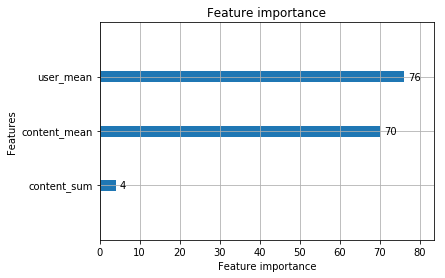

In [18]:
lgb.plot_importance(model)
plt.show()

In [19]:
if not kaggle_env:
    !jupyter nbconvert --to script kaggle_problems/riiid_test_answer_prediction/lightGB_benchmark.ipynb

[NbConvertApp] Converting notebook kaggle_problems/riiid_test_answer_prediction/lightGB_benchmark.ipynb to script
[NbConvertApp] Writing 11267 bytes to kaggle_problems/riiid_test_answer_prediction/lightGB_benchmark.py


In [20]:
# model = pickle.load(open(model_dir / "benchmark_model.pkl", 'rb'))
# data = pickle.load(open(FILE_LIST[-1], 'rb'))
# data = enrich_features(data)
# data = feature_transform(data)
# data = data[features].reset_index(drop=True)

In [21]:
# data.sample(1)

In [22]:
# model.predict(data)